# Peter en de Wolf: Realistische Omgeving

In ons scenario kon Peter zich bijna zonder moe te worden of honger te krijgen verplaatsen. In een realistischere wereld moet hij af en toe gaan zitten om uit te rusten en zichzelf voeden. Laten we onze wereld realistischer maken door de volgende regels toe te passen:

1. Door van de ene plek naar de andere te bewegen, verliest Peter **energie** en krijgt hij wat **vermoeidheid**.
2. Peter kan meer energie krijgen door appels te eten.
3. Peter kan van zijn vermoeidheid afkomen door uit te rusten onder een boom of op het gras (bijvoorbeeld door naar een bordlocatie met een boom of gras - groen veld - te lopen).
4. Peter moet de wolf vinden en doden.
5. Om de wolf te doden, moet Peter bepaalde niveaus van energie en vermoeidheid hebben, anders verliest hij het gevecht.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

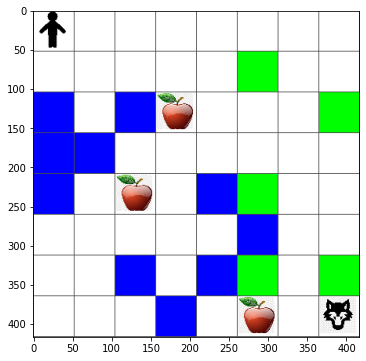

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Het definiëren van de toestand

In onze nieuwe spelregels moeten we energie en vermoeidheid bijhouden in elke bordtoestand. Daarom zullen we een object `state` maken dat alle benodigde informatie over de huidige probleemtoestand bevat, inclusief de toestand van het bord, de huidige niveaus van energie en vermoeidheid, en of we de wolf kunnen verslaan in de eindtoestand:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Laten we proberen het probleem op te lossen met een random walk en kijken of we slagen:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Beloningsfunctie

De beloningsfunctie is een cruciaal onderdeel van het trainingsproces. Het bepaalt hoe goed een actie is in een bepaalde toestand en stuurt het gedrag van de agent.

### Belangrijkste overwegingen

- **Duidelijkheid en eenvoud**: Zorg ervoor dat de beloningsfunctie eenvoudig te begrijpen is en geen onbedoelde gevolgen heeft.
- **Afstemming op doelen**: De beloningen moeten in lijn zijn met de gewenste uitkomsten. Als de beloning niet goed is afgestemd, kan de agent ongewenst gedrag vertonen.
- **Balans tussen korte- en langetermijndoelen**: Het is belangrijk om een evenwicht te vinden tussen onmiddellijke beloningen en beloningen die op de lange termijn voordelig zijn.

### Voorbeeld van een beloningsfunctie

Hier is een voorbeeld van een eenvoudige beloningsfunctie:

```python
def reward_function(state, action):
    if state == "goal_state":
        return 100  # Hoge beloning voor het bereiken van het doel
    elif action == "invalid_action":
        return -10  # Straf voor een ongeldige actie
    else:
        return -1  # Kleine straf voor elke stap om efficiëntie te bevorderen
```

### Veelvoorkomende valkuilen

- **Overoptimalisatie**: Als de beloningsfunctie te specifiek is, kan de agent leren om alleen die specifieke gevallen te optimaliseren, terwijl andere belangrijke aspecten worden genegeerd.
- **Onbedoelde beloningen**: Controleer of de beloningsfunctie geen gedrag beloont dat niet gewenst is.
- **Complexiteit**: Een te complexe beloningsfunctie kan moeilijk te debuggen zijn en kan leiden tot onvoorspelbaar gedrag.

### Testen en itereren

Het ontwerpen van een goede beloningsfunctie is vaak een iteratief proces. Test de beloningsfunctie grondig en observeer het gedrag van de agent. Pas de functie aan indien nodig om betere resultaten te bereiken.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning algoritme

Het daadwerkelijke leeralgoritme blijft grotendeels ongewijzigd, we gebruiken alleen `state` in plaats van alleen de bordpositie.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

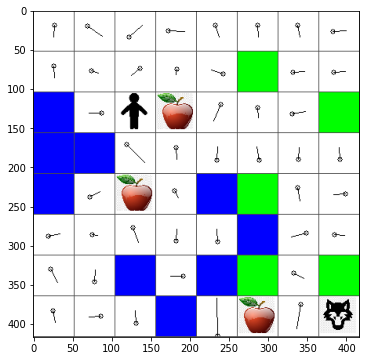

In [11]:
m.plot(Q)

## Resultaten

Laten we kijken of we erin geslaagd zijn om Peter te trainen om tegen de wolf te vechten!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


We zien nu veel minder gevallen van verdrinking, maar Peter is nog steeds niet altijd in staat om de wolf te doden. Probeer te experimenteren en kijk of je dit resultaat kunt verbeteren door met hyperparameters te spelen.


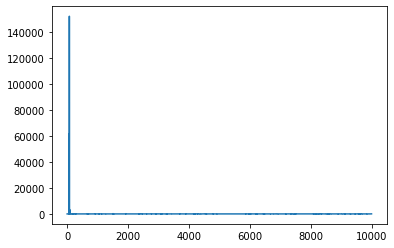

In [13]:
plt.plot(lpath)


---

**Disclaimer**:  
Dit document is vertaald met behulp van de AI-vertalingsservice [Co-op Translator](https://github.com/Azure/co-op-translator). Hoewel we streven naar nauwkeurigheid, willen we u erop wijzen dat geautomatiseerde vertalingen fouten of onnauwkeurigheden kunnen bevatten. Het originele document in de oorspronkelijke taal moet worden beschouwd als de gezaghebbende bron. Voor kritieke informatie wordt professionele menselijke vertaling aanbevolen. Wij zijn niet aansprakelijk voor misverstanden of verkeerde interpretaties die voortvloeien uit het gebruik van deze vertaling.
